In [1]:
import numpy as np
import scanpy as sc
import matplotlib.patches as patches
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_pcc=pd.read_csv('/SABench/FeatureSimilarity/MOB_GeneBased_PCC.csv',index_col=0,header=0)
df_cos_sim=pd.read_csv('/SABench/FeatureSimilarity/MOB_GeneBased_Cos_Sim.csv',index_col=0,header=0)
df_ssim=pd.read_csv('/SABench/FeatureSimilarity/MOB_GeneBased_SSIM.csv',index_col=0,header=0)
df_MI=pd.read_csv('/SABench/FeatureSimilarity/MOB_GeneBased_MI.csv',index_col=0,header=0)

In [3]:
for df in [df_pcc, df_cos_sim, df_ssim, df_MI]:    
    df.index = df.index.str.replace('_MOB', '')
groups_names=['PASTE','PASTE_p0','PASTE2','STAligner_landmark0','STAligner_landmark1','STAligner_landmark2','STAligner_landmark3','STAligner_landmark4','SLAT','STalign','CAST','STAIR','Spateo_rigid','Spateo_nonrigid','SANTO']

In [4]:
def custom_horizontal_boxplot_final(
    data_list, groups_names,
    colors=sns.color_palette('Paired') + sns.color_palette('Pastel1'),
    titles=None,
    xlabel='Score',
    figsize=(16, 4),
    score_annotations=None
):
  
    mean_values = [data.mean(axis=1) for data in data_list]
    mean_df = pd.concat(mean_values, axis=1)
    mean_df.columns = [f"Metric_{i}" for i in range(len(data_list))]

    rank_df = mean_df.rank(axis=0, ascending=False,method='max')
 
    mean_df['Overall'] = rank_df.mean(axis=1)
    mean_df['Rank'] = mean_df['Overall'].rank(ascending=True,method='max').astype(int)
   
    fig, axes = plt.subplots(1, len(data_list), figsize=figsize, dpi=300, sharey=False,
    gridspec_kw={'width_ratios': [0.8] * len(data_list)} )
    if len(data_list) == 1:
        axes = [axes]

    y_positions = np.arange(1, len(groups_names) + 1)
    plt.subplots_adjust(right=0.85)

    for i, (ax, data, title) in enumerate(zip(axes, data_list, titles)):
        data_reindexed = data.reindex(groups_names)
        data_transposed = data_reindexed.T

        bp = ax.boxplot(
            data_transposed,
            vert=False,
            patch_artist=True,
            widths=0.6,
            showcaps=True,
            showfliers=False,
            zorder=2
        )

        for j, (patch, color) in enumerate(zip(bp['boxes'], colors)):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)
            patch.set_edgecolor('#444444')
            patch.set_linewidth(1)
        for element in ['medians', 'whiskers', 'caps']:
            for line in bp[element]:
                line.set(color='#444444', linewidth=1)

        for j, group in enumerate(groups_names):
            y = y_positions[j]
            x_values = data_reindexed.loc[group].dropna()
            jitter = np.random.normal(loc=0, scale=0.1, size=len(x_values))
            ax.scatter(
                x_values.values,
                y + jitter,
                alpha=0.8,
                s=50,
                color=colors[j],
                edgecolors='black',
                linewidths=0.5,
                zorder=3
            )

        if 'PASTE2' in groups_names:
            a_index = groups_names.index('PASTE2')
            ax.axhline(y=y_positions[a_index] - 0.5, color='gray', linestyle=(0, (30, 8)),
                       linewidth=1, alpha=0.5, xmin=0.0, xmax=0.95)
        if 'SLAT' in groups_names:
            b_index = groups_names.index('SLAT')
            ax.axhline(y=y_positions[b_index] + 0.5, color='gray', linestyle=(0, (30, 8)),
                       linewidth=1, alpha=0.5, xmin=0.0, xmax=0.95)

        if i == 0:
            ax.set_yticks(y_positions)
            ax.set_yticklabels(groups_names)
            for label in ax.get_yticklabels():
                label.set_horizontalalignment('right')
                label.set_x(-0.1)
        else:
            ax.set_yticks([])

        ax.tick_params(axis='y', left=False)
        ax.set_ylim(0.5, len(groups_names) + 0.5)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_title(title, y=-0.2, fontsize=11)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)

        if i < len(data_list) - 1:
            ax.set_xlim(-0.25, 1)
            ax.set_xticks((-0.25,0,0.5, 1))  
            for xline in [0, 0.5]:
                ax.axvline(x=xline, color='gray', linestyle=(0, (20, 4)), linewidth=0.5)
        else:
            max_val = max([data_reindexed.loc[g].max() for g in groups_names])
            ax.set_xlim(0, max_val+0.05 )

            for xline in [0.2, 0.4]:
                ax.axvline(x=xline, color='gray', linestyle=(0, (20, 4)), linewidth=0.5)

            for j, group in enumerate(groups_names):
                rank = mean_df.loc[group, 'Rank']
                rank_str = f'{rank:02d}'  
                ax.text(
                    1.15, y_positions[j], rank_str,
                    transform=ax.get_yaxis_transform(),
                    ha='center', va='center',
                    fontfamily='monospace',
                    fontsize=9,
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor=colors[j],
                        edgecolor='black',
                        linewidth=0.5,
                        alpha=0.6
                    )
                )

            ax.annotate(
                'Overall\n Rank',
                xy=(0.95, 0),
                xycoords=('axes fraction', 'axes fraction'),
                xytext=(35, -30),
                textcoords='offset points',
                ha='center',
                va='top',
                fontsize=9,
                fontweight='bold'
            )

            axes[0].annotate(
                'Method',
                xy=(-0.02, 0),  
                xycoords=('axes fraction', 'axes fraction'),
                xytext=(-40, -30),  
                textcoords='offset points',
                ha='center',
                va='top',
                fontsize=10,
                fontweight='bold'
            ) 

    fig.add_artist(plt.Line2D(
        [0.1, 0.1], [0.1, 1],
        transform=fig.transFigure,
        color='black', linestyle=(0, (30, 5)), linewidth=1, alpha=1
    ))

    fig.add_artist(plt.Line2D(
        [0.81, 0.81], [0.1, 1],
        transform=fig.transFigure,
        color='black', linestyle=(0, (30, 5)), linewidth=1, alpha=1
    ))   

    plt.tight_layout(pad=0.5)
    plt.subplots_adjust(right=0.8)
    plt.show()

    return mean_df.sort_values('Rank')

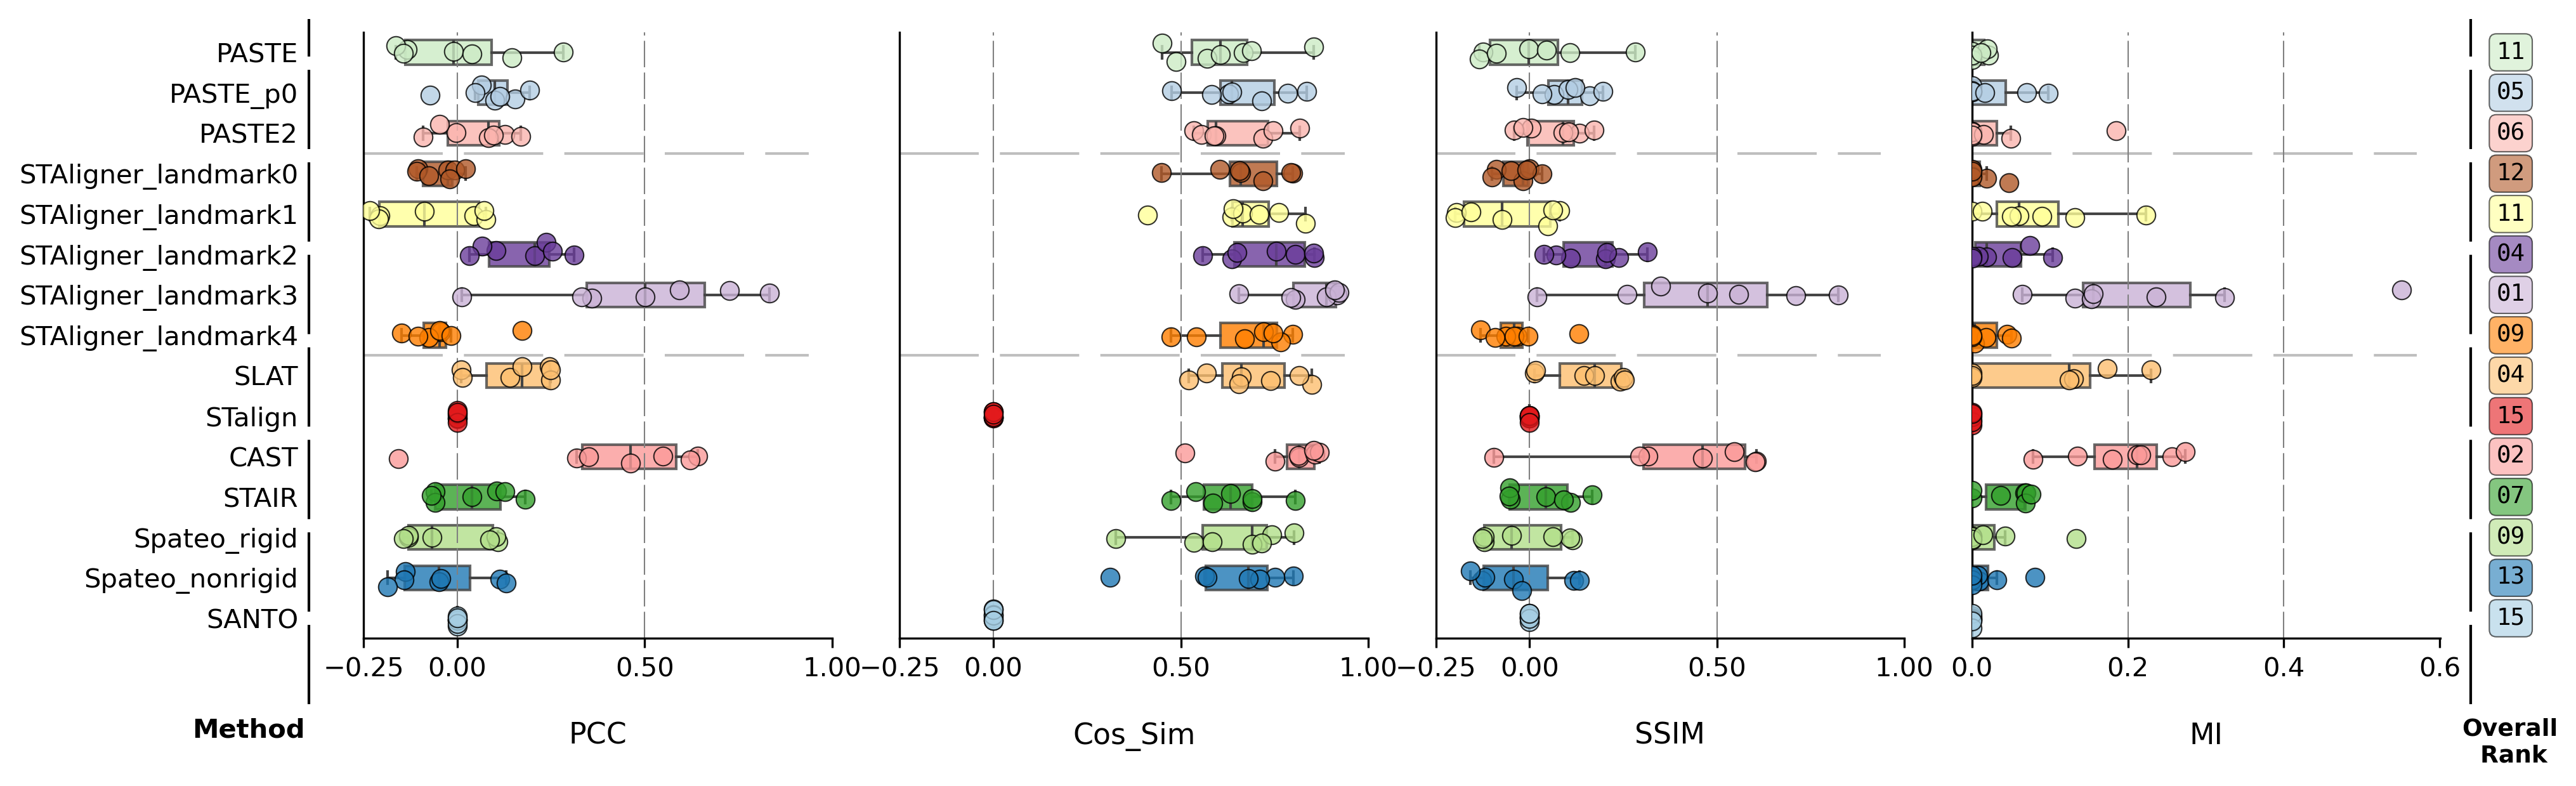

In [5]:
result = custom_horizontal_boxplot_final(
    data_list=[df_pcc, df_cos_sim, df_ssim, df_MI],
    groups_names=groups_names[::-1],
    titles=['PCC', 'Cos_Sim', 'SSIM', 'MI'],
    xlabel=''
)